In [362]:
!pip install yfinance

In [363]:
#Importing all libraries needed for the project.

import numpy as np 
import pandas as pd
import yfinance as yf
import torch
import matplotlib.pyplot as plt
import random
import time
import copy
import collections
from IPython import embed

In [364]:
def download_dataset(stocks=['AAPL', 'MSFT'], start='1990-01-01', end='2023-01-01'):
    """This function downloads the stock data for 5 stocks from yahoo finance in a certain time window.
    
    Arguments
    ---------
    stocks : list
        The tickers of the stocks that will be traded.
    start : string
        The start date of the dataset. Has to be the format YYYY-MM-DD (example:2000-01-01)
    end: string
        The end date of the dataset. Has to be the format YYYY-MM-DD (example:2023-01-01)
    
    Returns
    ---------
    full_dataset : pandas.core.frame.DataFrame
        Dataframe containing stocks, vix and nasdaq price and volume information.
    
    """
    
    
    #Downloading stock data to be used
    stock1_df=yf.download(stocks[0], start=start, end=end, progress=True)
    stock2_df=yf.download(stocks[1], start=start, end=end, progress=True)
    
    #Downloading VIX index data to be used. VIX is a volatility index for the market.
    vix_df=yf.download('^VIX', start=start, end=end, progress=True)
    
    #Downloading NASDAQ index data to be used. NASDAQ is a stock exchange mainly for tech stocks.
    nsdq_df=yf.download('^IXIC', start=start, end=end, progress=True)
    
    #Renaming the Columns
    stock1_df.rename(columns={'Open': f'{stocks[0]} Open', 'High': f'{stocks[0]} High', 'Low': f'{stocks[0]} Low', 'Close': f'{stocks[0]} Close', 'Adj Close': f'{stocks[0]} Adj Close', 'Volume': f'{stocks[0]} Volume'}, inplace=True)
    stock2_df.rename(columns={'Open': f'{stocks[1]} Open', 'High': f'{stocks[1]} High', 'Low': f'{stocks[1]} Low', 'Close': f'{stocks[1]} Close', 'Adj Close': f'{stocks[1]} Adj Close', 'Volume': f'{stocks[1]} Volume'}, inplace=True)
    vix_df.rename(columns={'Open': 'Vix Open', 'High': 'Vix High', 'Low': 'Vix Low', 'Close': 'Vix Close', 'Adj Close': 'Vix Adj Close', 'Volume': 'Vix Volume'}, inplace=True)
    nsdq_df.rename(columns={'Open': 'Nasdaq Open', 'High': 'Nasdaq High', 'Low': 'Nasdaq Low', 'Close': 'Nasdaq Close', 'Nasdaq Close': 'Nasdaq Adj Close', 'Volume': 'Nasdaq Volume'}, inplace=True)
    
    #Concatenating all dataset into one set.
    full_dataset=pd.concat([stock1_df, stock2_df, vix_df, nsdq_df], axis=1)
    
    #Dropping the column for the VIX index because the VIX does not have volume.
    full_dataset.drop(['Vix Volume'], axis=1, inplace=True)
    
    return full_dataset

In [365]:
stocks=['AAPL', 'MSFT']
observations = download_dataset(stocks)
prices = observations[[f'{stocks[0]} Adj Close', f'{stocks[1]} Adj Close']]
observations = observations.to_numpy()
prices = prices.to_numpy()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [366]:
window_shape = 64

In [367]:
split = 0.7

dataset_size = observations.shape[0]

train_cutoff = int(dataset_size * split)
val_cutoff = train_cutoff + int((dataset_size-train_cutoff)*(1-split))

train_obs = observations[:train_cutoff,:]
train_prices = prices[:train_cutoff,:]
val_obs = observations[train_cutoff-window_shape:val_cutoff,:]
val_prices = prices[train_cutoff-1:val_cutoff,:]
test_obs = observations[val_cutoff-window_shape:,:]
test_prices = prices[val_cutoff-1:,:]

In [368]:
train_obs_norm = (train_obs - np.min(train_obs, axis=0))/(np.max(train_obs, axis=0) - np.min(train_obs, axis=0))+0.1
train_prices_norm = (train_prices - np.min(train_prices, axis=0))/(np.max(train_prices, axis=0) - np.min(train_prices, axis=0))+0.1

val_obs_norm = (val_obs - np.min(val_obs, axis=0))/(np.max(val_obs, axis=0) - np.min(val_obs, axis=0))+0.1
val_prices_norm = (val_prices - np.min(val_prices, axis=0))/(np.max(val_prices, axis=0) - np.min(val_prices, axis=0))+0.1

test_obs_norm = (test_obs - np.min(test_obs, axis=0))/(np.max(test_obs, axis=0) - np.min(test_obs, axis=0))+0.1
test_prices_norm = (test_prices - np.min(test_prices, axis=0))/(np.max(test_prices, axis=0) - np.min(test_prices, axis=0))+0.1

In [369]:
from numpy.lib.stride_tricks import sliding_window_view

#Create sequences
train_seq = sliding_window_view(train_obs_norm, window_shape = window_shape, axis=0).swapaxes(1,2)
train_prices_seq = train_prices_norm[window_shape-1:,:]
train_prices_unnorm = train_prices[window_shape-1:,:]
val_seq = sliding_window_view(val_obs_norm, window_shape = window_shape, axis=0).swapaxes(1,2)
val_prices_seq = val_prices_norm
val_prices_unnorm = val_prices
test_seq = sliding_window_view(test_obs_norm, window_shape = window_shape, axis=0).swapaxes(1,2)
test_prices_seq = test_prices_norm
test_prices_unnorm = test_prices

In [370]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_seq_tensor = torch.from_numpy(train_seq).float()
train_prices_seq_tensor = torch.from_numpy(train_prices_seq).float()
train_prices_unnorm_tensor = torch.from_numpy(train_prices_unnorm).float()
val_seq_tensor = torch.from_numpy(val_seq).float()
val_prices_seq_tensor = torch.from_numpy(val_prices_seq).float()
val_prices_unnorm_tensor = torch.from_numpy(val_prices_unnorm).float()
test_seq_tensor = torch.from_numpy(test_seq).float()
test_prices_seq_tensor = torch.from_numpy(test_prices_seq).float()
test_prices_unnorm_tensor = torch.from_numpy(test_prices_unnorm).float()

In [371]:
# def offline_dataset(train_seq_tensor, train_prices_seq_tensor, commission=0.001):
    
#     all_actions = torch.tensor([[0, 0], [0, 1], [0, -1],
#                                 [1, 0], [1, 1], [1, -1],
#                                 [-1, 0], [-1, 1], [-1, -1]])
#     possible_actions = np.array([[0, 1, 2, 3, 4, 5, 6, 7, 8],
#                                  [0, 2, 3, 5, 6, 8],
#                                  [0, 1, 3, 4, 6, 7],
#                                  [0, 1, 2, 6, 7, 8],
#                                  [0, 2, 6, 8],
#                                  [0, 1, 6, 7],
#                                  [0, 1, 2, 3, 4, 5],
#                                  [0, 2, 3, 5], 
#                                  [0, 1, 3, 4]], dtype=object)
    
#     # Create states with all possible holdings
#     states_repeated = train_seq_tensor.repeat_interleave(9, dim=0)
#     states_repeated = torch.cat((states_repeated[0:1,:,:], states_repeated[9:,:,:]), dim=0)
#     prices_repeated = train_prices_seq_tensor.repeat_interleave(9, dim=0)
#     prices_repeated = torch.cat((prices_repeated[0:1,:], prices_repeated[9:,:]), dim=0)
#     all_holdings = all_actions.unsqueeze(1).repeat(train_seq_tensor.shape[0], train_seq_tensor.shape[1], 1)
#     all_holdings = torch.cat((all_holdings[0:1,:], all_holdings[9:,:]), dim=0)
#     new_states = torch.cat((states_repeated, all_holdings), dim=-1)
    
#     #Create actions
#     tuple_list = []
#     length = new_states.shape[0]-9
#     for i in range(length):
#         current_state = new_states[i]
#         current_holding = new_states[i, 0, -2:]
#         holding_index = torch.nonzero(torch.all(torch.eq(current_holding, all_actions), dim=1))
#         legal_actions = possible_actions[holding_index[0].item()]
#         for action_index in legal_actions:
#             action = all_actions[action_index]
#             reward = torch.sum(torch.where((torch.absolute(current_holding)==torch.absolute(action)) & (current_holding!=0), -(action*prices_repeated[i])-prices_repeated[max(0, i-9)]*current_holding, 0))
#             reward = reward - torch.sum(torch.absolute(action)*prices_repeated[i]*commission)
#             next_holding = current_holding+action
#             holding_index = torch.nonzero(torch.all(torch.eq(next_holding, all_actions), dim=1))[0]
#             next_state = new_states[i+9].clone().detach()
#             next_state[:, -2:] = next_holding
#             if i >= (length-9):
#                 done = 1
#             else:
#                 done = 0
#             tuple_list.append((current_state, action_index, reward, next_state, holding_index, done))
#     return tuple_list

In [372]:
# tuple_list = offline_dataset(train_seq_tensor, train_prices_seq_tensor)

In [373]:
# def tuple_list_to_tensors(tuple_list):
#     states = torch.zeros(len(tuple_list),tuple_list[0][0].shape[0], tuple_list[0][0].shape[1])
#     actions = torch.zeros(len(tuple_list))
#     rewards = torch.zeros(len(tuple_list))
#     next_states = torch.zeros(len(tuple_list),tuple_list[0][3].shape[0], tuple_list[0][3].shape[1])
#     holding_index = np.zeros(len(tuple_list), dtype=int)
#     dones = torch.zeros(len(tuple_list))
#     for i, tuples in enumerate(tuple_list):
#         states[i] = tuples[0]
#         actions[i] = tuples[1]
#         rewards[i] = tuples[2]
#         next_states[i] = tuples[3]
#         holding_index[i] = tuples[4]
#         dones[i] = tuples[5]
#     return states.to(device), actions.long().to(device), rewards.to(device), next_states, holding_index, dones.to(device)

In [374]:
# states, actions, rewards, next_states, holding_index, dones = tuple_list_to_tensors(tuple_list)

In [375]:
class Trading_Env():
    def __init__(self, observations, prices, unnorm_prices, commission=0):
        self.iter = 0
        self.prev_prices = torch.zeros(prices.shape[1])
        self.unnorm_prev_prices = torch.zeros(unnorm_prices.shape[1])
        self.holdings = torch.zeros(prices.shape[1])
        self.holding_index = None
        self.terminated = torch.tensor([0])
        self.observations = observations
        self.prices = prices
        self.unnorm_prices = unnorm_prices
        self.all_actions = torch.from_numpy(np.array([[0, 0], [0, 1], [0, -1],
                                                      [1, 0], [1, 1], [1, -1],
                                                      [-1, 0], [-1, 1], [-1, -1]]))
        self.commission = torch.tensor([commission, commission])
    def reset(self):
        self.iter = 0
        self.prev_prices = self.prices[self.iter]
        self.unnorm_prev_prices = self.unnorm_prices[self.iter]
        self.holdings = torch.zeros(prices.shape[1])
        self.holding_index = torch.tensor([0])
        self.terminated = torch.tensor([0])
        
        return torch.cat((self.observations[self.iter], self.holdings.unsqueeze(0).repeat(self.observations[self.iter].shape[0], 1)), dim=1)
        
    def step(self, action):
        action = self.all_actions[action]
        reward = torch.sum(torch.where((torch.absolute(self.holdings)==torch.absolute(action)) & (self.holdings!=0), -(action*self.prices[self.iter])-self.prev_prices*self.holdings, 0), dim=-1, keepdim=True)
        reward = reward - torch.sum(torch.absolute(action)*self.prices[self.iter]*self.commission, dim=-1, keepdim=True)
        gain = torch.sum(torch.where((torch.absolute(self.holdings)==torch.absolute(action)) & (self.holdings!=0), -(action*self.unnorm_prices[self.iter])-self.unnorm_prev_prices*self.holdings, 0), dim=-1, keepdim=True)
        gain = gain - torch.sum(torch.absolute(action)*self.unnorm_prices[self.iter]*self.commission, dim=-1, keepdim=True)
        self.holdings = self.holdings + action
        self.holding_index = torch.nonzero(torch.all(torch.eq(self.holdings, self.all_actions), dim=1))[0][0]
        self.prev_prices = torch.absolute(action)*self.prices[self.iter]+(1-torch.absolute(action))*self.prev_prices
        self.unnorm_prev_prices = torch.absolute(action)*self.unnorm_prices[self.iter]+(1-torch.absolute(action))*self.unnorm_prev_prices
        self.iter += 1
        if self.iter == self.prices.shape[0]-1:
            self.terminated = torch.tensor([1])
        return torch.cat((self.observations[self.iter], (self.holdings*self.prev_prices).unsqueeze(0).repeat(self.observations[self.iter].shape[0], 1)), dim=1), reward, gain, self.holding_index, self.terminated

In [376]:
env = Trading_Env(train_seq_tensor, train_prices_seq_tensor, train_prices_unnorm_tensor, )

In [377]:
obs0 = env.reset()

In [378]:
print(obs0)

tensor([[0.1080, 0.1086, 0.1080,  ..., 0.1147, 0.0000, 0.0000],
        [0.1090, 0.1088, 0.1089,  ..., 0.1240, 0.0000, 0.0000],
        [0.1091, 0.1091, 0.1088,  ..., 0.1230, 0.0000, 0.0000],
        ...,
        [0.1101, 0.1101, 0.1101,  ..., 0.1177, 0.0000, 0.0000],
        [0.1097, 0.1099, 0.1098,  ..., 0.1183, 0.0000, 0.0000],
        [0.1097, 0.1098, 0.1096,  ..., 0.1149, 0.0000, 0.0000]])


In [379]:
obs0, reward0, gain0, hi0, done0 = env.step(8)

In [380]:
prices0 = env.prev_prices
print(prices0)
print(reward0)
print(gain0)
print(hi0)
print(done0)

tensor([0.1088, 0.1030])
tensor([0.])
tensor([0.])
tensor(8)
tensor([0])


In [381]:
print(env.all_actions[hi0])

tensor([-1, -1])


In [382]:
obs1, reward1, gain1, hi1, done1 = env.step(0)

In [383]:
prices1 = env.prev_prices
print(prices1)
print(reward1)
print(gain1)
print(hi1)
print(done1)

tensor([0.1088, 0.1030])
tensor([0.])
tensor([0.])
tensor(8)
tensor([0])


In [384]:
obs2, reward2, gain2, hi2, done2 = env.step(0)

In [385]:
prices2 = env.prev_prices
print(prices2)

print(reward2)
print(gain2)
print(hi2)
print(done2)

tensor([0.1088, 0.1030])
tensor([0.])
tensor([0.])
tensor(8)
tensor([0])


In [386]:
obs3, reward3, gain3, hi3, done3 = env.step(1)

In [387]:
prices3 = env.prev_prices
print(prices3)
print(reward3)
print(gain3)
print(hi3)
print(done3)
print(prices0[1].item()-prices3[1].item())

tensor([0.1088, 0.1033])
tensor([-0.0004])
tensor([-0.0130])
tensor(6)
tensor([0])
-0.00035331398248672485


In [388]:
print(obs3)

tensor([[ 0.1088,  0.1088,  0.1087,  ...,  0.1158, -0.1088,  0.0000],
        [ 0.1090,  0.1088,  0.1087,  ...,  0.1193, -0.1088,  0.0000],
        [ 0.1088,  0.1087,  0.1083,  ...,  0.1221, -0.1088,  0.0000],
        ...,
        [ 0.1102,  0.1102,  0.1101,  ...,  0.1209, -0.1088,  0.0000],
        [ 0.1101,  0.1100,  0.1098,  ...,  0.1200, -0.1088,  0.0000],
        [ 0.1098,  0.1100,  0.1097,  ...,  0.1205, -0.1088,  0.0000]])


In [389]:
import torch.nn as nn 
import torch.nn.functional as F

class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads=8, dropout=0.1):
        
        super().__init__()

        self.layer_norm1 = nn.LayerNorm(embed_dim)
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.layer_norm2 = nn.LayerNorm(embed_dim)
        self.linear1 = nn.Linear(embed_dim, embed_dim)
        self.linear2 = nn.Linear(embed_dim, embed_dim)

        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        x1 = x
        x = self.layer_norm1(x1)
        x, _ = self.attention(x, x, x)
        x = self.relu(x)
        x = self.dropout(x)
        x2 = x + x1
        x = self.layer_norm2(x2)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = x + x2

        return x

class Transformer(nn.Module):
    def __init__(self, features, embed_dim, seq_length,
                 num_heads=8, num_layers = 6, dropout=0.1):
        super(Transformer, self).__init__()
        self.positional_encoding = nn.Parameter(torch.rand(seq_length, embed_dim))
        self.linear1 = nn.Linear(features, embed_dim)

        self.layers = nn.ModuleList([TransformerEncoder(embed_dim, num_heads, dropout) for i in range(num_layers)])

        self.layer_norm = nn.LayerNorm(embed_dim)
        
        self.value = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim, 1)
        )

        self.advantage = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim, 9)
        )
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.linear1(x)
        x = x + self.positional_encoding
        x = self.dropout(x)
        for i, l in enumerate(self.layers):
            x = l(x)
            
        x = self.layer_norm(x)
        value = self.value(x)
        advantage = self.advantage(x)
        x = torch.add(value, (advantage - advantage.mean(dim=-1, keepdim=True)))
        if x.dim() == 3:
            x = x[:, -1, :]
        else:
            x = x[-1,:]
        return x

In [390]:
import torch.nn.functional as F

class Double_Q_Learning_Agent():
    def __init__(self, train_seq, train_prices_seq, train_prices_unnorm, val_seq, val_prices_seq, 
                 val_prices_unnorm, test_seq, test_prices_seq, test_prices_unnorm, lr, batch_size, eps, buffer_size,
                 sync_steps, seed):
    
        self.lr = lr
        self.batch_size = batch_size
        self.gamma = 0.99
        self.eps = eps
        self.buffer_size = buffer_size
        self.sync_steps = sync_steps
        
        np.random.seed(seed)
        torch.manual_seed(seed)
        random.seed(seed)
        
        self.all_actions = torch.tensor([[0, 0], [0, 1], [0, -1],
                                         [1, 0], [1, 1], [1, -1],
                                         [-1, 0], [-1, 1], [-1, -1]]).to(device)
        
        self.legal_actions = torch.tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0],
                                       [0, -1e10, 0, 0, -1e10, 0, 0, -1e10, 0],
                                       [0, 0, -1e10, 0, 0, -1e10, 0, 0, -1e10],
                                       [0, 0, 0, -1e10, -1e10, -1e10, 0, 0, 0],
                                       [0, -1e10, 0, -1e10, -1e10, -1e10, 0, -1e10, 0],
                                       [0, 0, -1e10, -1e10, -1e10, -1e10, 0, 0, -1e10],
                                       [0, 0, 0, 0, 0, 0, -1e10, -1e10, -1e10],
                                       [0, -1e10, 0, 0, -1e10, 0, -1e10, -1e10, -1e10], 
                                       [0, 0, -1e10, 0, 0, -1e10, -1e10, -1e10, -1e10]]).to(device)
        
        self.train_env = Trading_Env(train_seq, train_prices_seq, train_prices_unnorm)
        self.val_env = Trading_Env(val_seq, val_prices_seq, val_prices_unnorm)
        self.test_env = Trading_Env(test_seq, test_prices_seq, test_prices_unnorm)
        
        self.q_fun1 = Transformer(features=25, embed_dim=128, seq_length=window_shape,
                                  num_heads=4, num_layers = 3, dropout=0.1).to(device)
        self.q_fun2 = Transformer(features=25, embed_dim=128, seq_length=window_shape,
                                  num_heads=4, num_layers = 3, dropout=0.1).to(device)
        
        self.q_fun1_target = copy.deepcopy(self.q_fun1)
        self.q_fun2_target = copy.deepcopy(self.q_fun2)
        
        self.optimizer1 = torch.optim.Adam(self.q_fun1.parameters(), lr=self.lr)
        self.optimizer2 = torch.optim.Adam(self.q_fun2.parameters(), lr=self.lr)
        
        class ReplayBuffer:
            def __init__(self, buffer_size):
                self.buffer = collections.deque(maxlen=buffer_size)
            
            def length(self):
                return len(self.buffer)
            
            def append(self, sample):
                self.buffer.append(sample)

            def sample(self, batch_size):
                indices = np.random.choice(len(self.buffer), batch_size, replace=False)
                states = [self.buffer[idx][0] for idx in indices]
                actions = [self.buffer[idx][1] for idx in indices]
                rewards = [self.buffer[idx][2] for idx in indices]
                next_states = [self.buffer[idx][3] for idx in indices]
                gains = [self.buffer[idx][4] for idx in indices]
                hold_indices = [self.buffer[idx][5] for idx in indices]
                dones = [self.buffer[idx][6] for idx in indices]
                return torch.stack(states, dim=0).to(device), torch.stack(actions, dim=0).to(device), torch.stack(rewards, dim=0).to(device), torch.stack(next_states, dim=0).to(device), torch.stack(gains, dim=0).to(device), torch.stack(hold_indices, dim=0).to(device), torch.stack(dones, dim=0).to(device)       
        
        self.replay_buffer = ReplayBuffer(self.buffer_size)
        
    def train(self, episodes):
        sync_step = 1
        env = self.train_env
        ep_gains_list = []
        for e in range(episodes):
            # reset the env in a "random" state
            obs = env.reset()
            done = False
            step = 1
            target = None
            ep_gains = 0
            while not done:
                if step % 100 == 0:
                    print(f"Step: {step}/{env.observations.shape[0]}")
                # query the Q-function to get an action
                action = self.get_action(obs, env).cpu()
                # step the environment
                next_obs, reward, gain, holding_index, terminated = env.step(action)
                # append sample to replay buffer
                sample = (obs, action, reward, next_obs, gain, holding_index, terminated)
                self.replay_buffer.append(sample)
                # update q_value
                if self.replay_buffer.length() >= self.batch_size:
                    states_batch, actions_batch, rewards_batch, next_states_batch, gains_batch, holding_index_batch, dones_batch = self.replay_buffer.sample(self.batch_size)
                    loss, target = self.q_update(states_batch, actions_batch, rewards_batch, next_states_batch, holding_index_batch, dones_batch)
                    sync_step += 1
                # accumulate rewards
                ep_gains += gain
                # step obs
                obs = next_obs
                # end episode
                step += 1
                if terminated:
                    done = True
                    break
                
                if sync_step % sync_steps == 0:
                    self.q_fun1_target = copy.deepcopy(self.q_fun1)
                    self.q_fun2_target = copy.deepcopy(self.q_fun2)
            ep_gains_list.append(ep_gains.numpy())    
            if e % 1 == 0:
                print(f"Episode={e+1}/{episodes},    Loss: {loss.item()},    Gain: {ep_gains}")
                print()
        return ep_gains_list
    
    def q_update(self, s, a, r, next_s, h, d):

            choice = np.random.choice(2)

            if choice == 0:
                with torch.no_grad():
                    # compute TD target
                    legal_actions = self.legal_actions[h]
                    max_actions = torch.argmax(torch.add(self.q_fun1_target(next_s), legal_actions), dim=-1, keepdim=True)
#                     embed()
                    target = torch.add(r, (1-d) * self.gamma * self.q_fun2_target(next_s).gather(1, max_actions))
                    
                # Compute TD error
                prediction = self.q_fun1(s).gather(1, a.unsqueeze(-1))
                
                self.optimizer1.zero_grad()

                loss = F.huber_loss(prediction, target)
                loss.backward()

                self.optimizer1.step()
                
                return loss, target

            else:
                with torch.no_grad():
                    # compute TD target
                    legal_actions = self.legal_actions[h]
                    max_actions = torch.argmax(torch.add(self.q_fun2_target(next_s), legal_actions), dim=-1, keepdim=True)
                    target = torch.add(r, (1-d) * self.gamma * self.q_fun1_target(next_s).gather(1, max_actions))
                    
                # Compute TD error
                prediction = self.q_fun2(s).gather(1, a.unsqueeze(-1))

                self.optimizer2.zero_grad()

                loss = F.huber_loss(prediction, target)
                loss.backward()

                self.optimizer2.step()
                return loss, target
            
    def run_one_episode(self, mode="train"):
        ep_gains = []
        # reset the env in a "random" state
        if mode == "train":
            env = self.train_env
        elif mode == "val":
            env = self.val_env
        else: 
            env = self.test_env
        
        obs = env.reset().to(device)
        done = False
        step = 1
        target = None
        start = time.time()
        while not done:
            if step % 100 == 0:
                print(f"Step: {step}/{env.observations.shape[0]}")
            # query the Q-function to get an action
            action = self.get_action(obs, env).cpu()
            # step the environment
            next_obs, reward, gain, holding_index, terminated = env.step(action)
            # accumulate rewards
            ep_gains.append(gain.numpy())
            # step obs
            obs = next_obs.to(device)
            # end episode
            step += 1
            if terminated:
                done = True
                break

        return ep_gains

    def get_action(self, obs, env, train = True):
        """Get action using epsilon-greedy strategy"""
        with torch.no_grad():
            if train and np.random.random() < eps:
                holding_index = env.holding_index
                legal_actions = np.argwhere(self.legal_actions[holding_index].cpu().numpy() == 0)
                action = np.random.choice(legal_actions[1])
                return torch.tensor([action])[0]
            else:
                obs = obs.to(device)
                holding_index = env.holding_index
                action_mask = self.legal_actions[holding_index]
                func1_values = torch.add(self.q_fun1(obs), action_mask)
                func2_values = torch.add(self.q_fun2(obs), action_mask)
                avg_values = torch.add(func1_values, func2_values)/2
                max_action_index = torch.argmax(avg_values)
                return max_action_index

In [391]:
episodes = 20
lr = 0.0001
seed = 0
eps = 0.1
sync_steps = 100
batch_size = 128
buffer_size = 10000
agent = Double_Q_Learning_Agent(train_seq_tensor, train_prices_seq_tensor, train_prices_unnorm_tensor, val_seq_tensor, 
                                val_prices_seq_tensor, val_prices_unnorm_tensor, test_seq_tensor, test_prices_seq_tensor, 
                                test_prices_unnorm_tensor, lr, batch_size, eps, buffer_size, sync_steps, seed)
episode_gains = agent.train(episodes)

Step: 100/5757
Step: 200/5757
Step: 300/5757
Step: 400/5757
Step: 500/5757
Step: 600/5757
Step: 700/5757
Step: 800/5757
Step: 900/5757
Step: 1000/5757
Step: 1100/5757
Step: 1200/5757
Step: 1300/5757
Step: 1400/5757
Step: 1500/5757
Step: 1600/5757
Step: 1700/5757
Step: 1800/5757
Step: 1900/5757
Step: 2000/5757
Step: 2100/5757
Step: 2200/5757
Step: 2300/5757
Step: 2400/5757
Step: 2500/5757
Step: 2600/5757
Step: 2700/5757
Step: 2800/5757
Step: 2900/5757
Step: 3000/5757
Step: 3100/5757
Step: 3200/5757
Step: 3300/5757
Step: 3400/5757
Step: 3500/5757
Step: 3600/5757
Step: 3700/5757
Step: 3800/5757
Step: 3900/5757
Step: 4000/5757
Step: 4100/5757
Step: 4200/5757
Step: 4300/5757
Step: 4400/5757
Step: 4500/5757
Step: 4600/5757
Step: 4700/5757
Step: 4800/5757
Step: 4900/5757
Step: 5000/5757
Step: 5100/5757
Step: 5200/5757
Step: 5300/5757
Step: 5400/5757
Step: 5500/5757
Step: 5600/5757
Step: 5700/5757
Episode=1/20,    Loss: 0.00020881230011582375,    Gain: tensor([-20.9337])

Step: 100/5757
Step: 

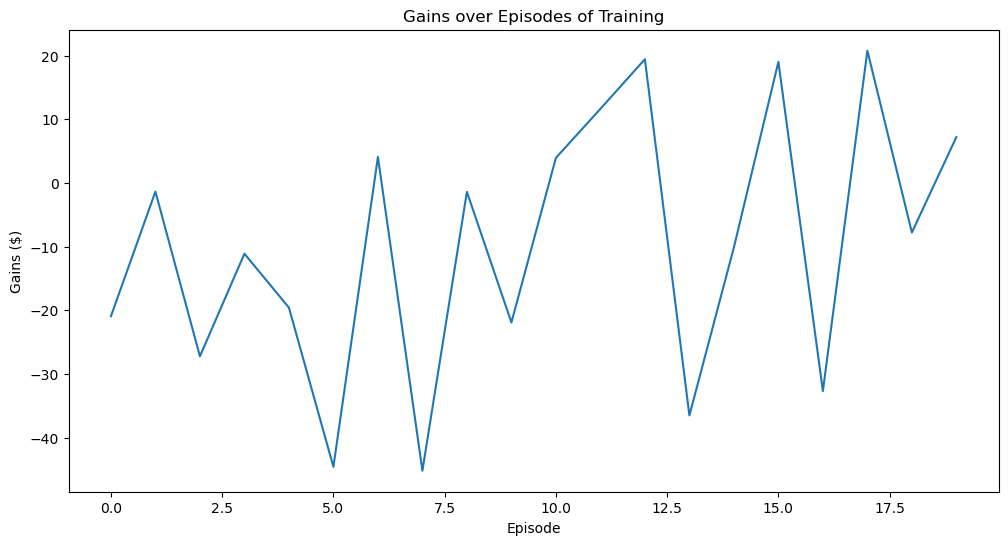

In [392]:
plt.figure(figsize=(12,6))
plt.plot(episode_gains)
plt.title("Gains over Episodes of Training")
plt.xlabel("Episode")
plt.ylabel("Gains ($)")
plt.show()

In [393]:
train_gains = agent.run_one_episode(mode="train")

Step: 100/5757
Step: 200/5757
Step: 300/5757
Step: 400/5757
Step: 500/5757
Step: 600/5757
Step: 700/5757
Step: 800/5757
Step: 900/5757
Step: 1000/5757
Step: 1100/5757
Step: 1200/5757
Step: 1300/5757
Step: 1400/5757
Step: 1500/5757
Step: 1600/5757
Step: 1700/5757
Step: 1800/5757
Step: 1900/5757
Step: 2000/5757
Step: 2100/5757
Step: 2200/5757
Step: 2300/5757
Step: 2400/5757
Step: 2500/5757
Step: 2600/5757
Step: 2700/5757
Step: 2800/5757
Step: 2900/5757
Step: 3000/5757
Step: 3100/5757
Step: 3200/5757
Step: 3300/5757
Step: 3400/5757
Step: 3500/5757
Step: 3600/5757
Step: 3700/5757
Step: 3800/5757
Step: 3900/5757
Step: 4000/5757
Step: 4100/5757
Step: 4200/5757
Step: 4300/5757
Step: 4400/5757
Step: 4500/5757
Step: 4600/5757
Step: 4700/5757
Step: 4800/5757
Step: 4900/5757
Step: 5000/5757
Step: 5100/5757
Step: 5200/5757
Step: 5300/5757
Step: 5400/5757
Step: 5500/5757
Step: 5600/5757
Step: 5700/5757


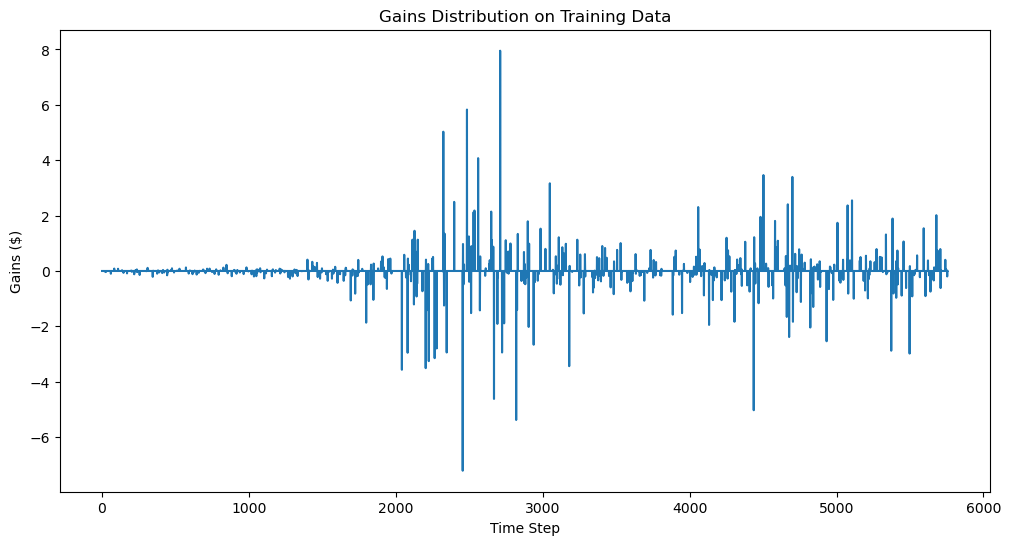

In [394]:
plt.figure(figsize=(12,6))
plt.plot(train_gains)
plt.title("Gains Distribution on Training Data")
plt.xlabel("Time Step")
plt.ylabel("Gains ($)")
plt.show()

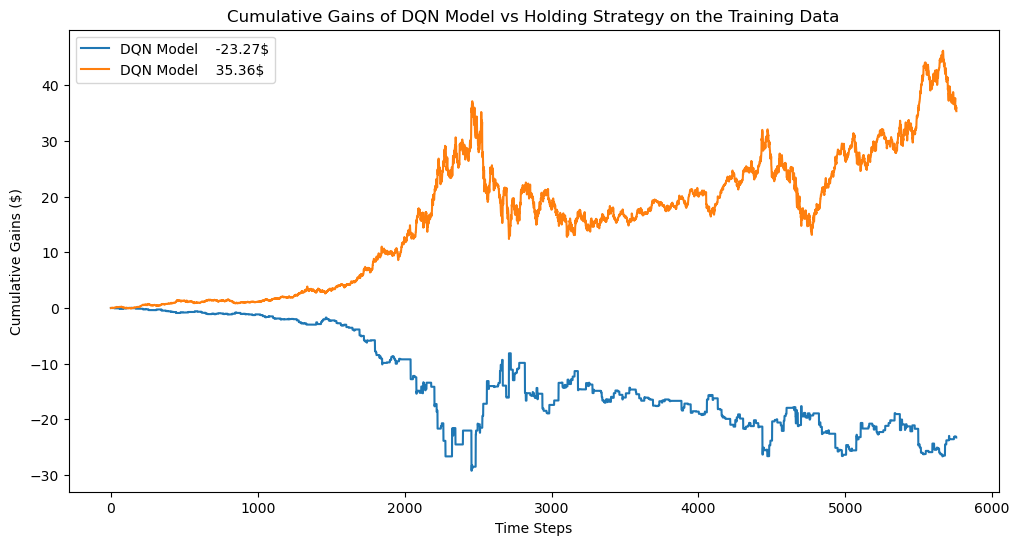

In [395]:
train_cumulative_gains = np.cumsum(train_gains)
plt.figure(figsize=(12,6))
plt.plot(train_cumulative_gains, label="DQN Model    {0:.2f}$".format(train_cumulative_gains[-1]))
train_holding_gains = np.sum(train_prices_unnorm-train_prices_unnorm[0], axis=1)
plt.plot(train_holding_gains, label="DQN Model    {0:.2f}$".format(train_holding_gains[-1]))
plt.title("Cumulative Gains of DQN Model vs Holding Strategy on the Training Data")
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Gains ($)")
plt.legend()
plt.show()

In [396]:
val_gains = agent.run_one_episode(mode="val")

Step: 100/749
Step: 200/749
Step: 300/749
Step: 400/749
Step: 500/749
Step: 600/749
Step: 700/749


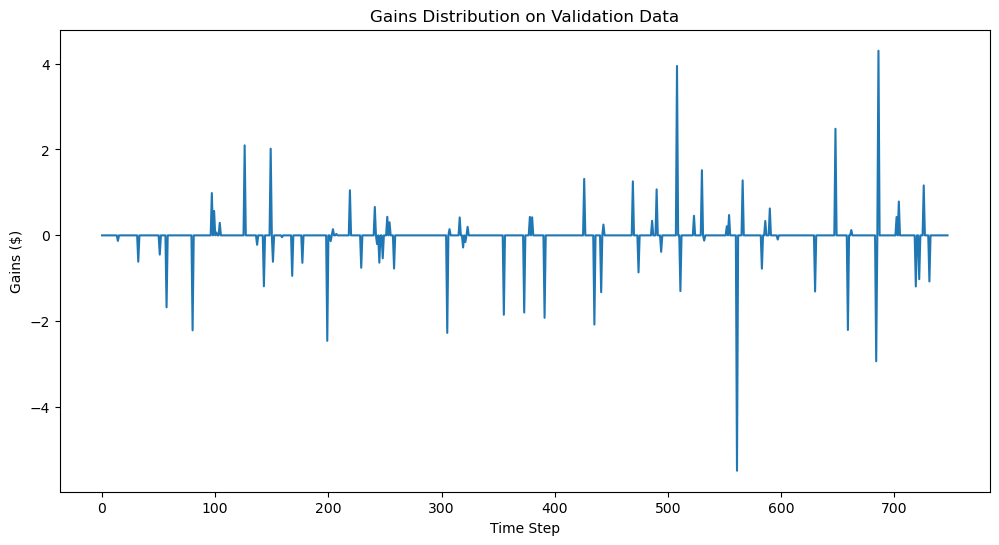

In [397]:
plt.figure(figsize=(12,6))
plt.plot(val_gains)
plt.title("Gains Distribution on Validation Data")
plt.xlabel("Time Step")
plt.ylabel("Gains ($)")
plt.show()

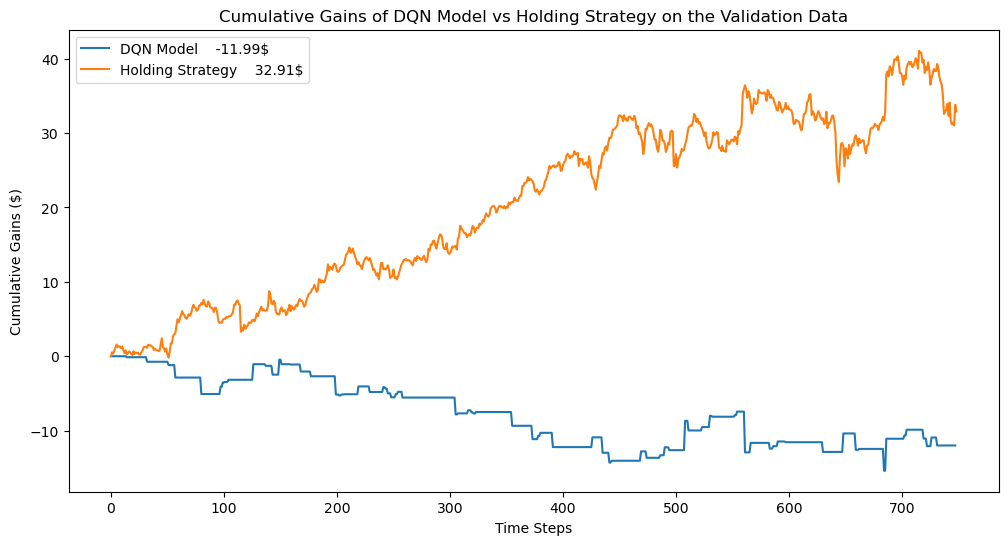

In [398]:
val_cumulative_gains = np.cumsum(val_gains)
plt.figure(figsize=(12,6))
plt.plot(val_cumulative_gains, label="DQN Model    {0:.2f}$".format(val_cumulative_gains[-1]))
val_holding_gains = np.sum(val_prices_unnorm-val_prices_unnorm[0], axis=1)
plt.plot(val_holding_gains, label="Holding Strategy    {0:.2f}$".format(val_holding_gains[-1]))
plt.title("Cumulative Gains of DQN Model vs Holding Strategy on the Validation Data")
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Gains ($)")
plt.legend()
plt.show()

In [399]:
test_gains = agent.run_one_episode(mode="test")

Step: 100/1748
Step: 200/1748
Step: 300/1748
Step: 400/1748
Step: 500/1748
Step: 600/1748
Step: 700/1748
Step: 800/1748
Step: 900/1748
Step: 1000/1748
Step: 1100/1748
Step: 1200/1748
Step: 1300/1748
Step: 1400/1748
Step: 1500/1748
Step: 1600/1748
Step: 1700/1748


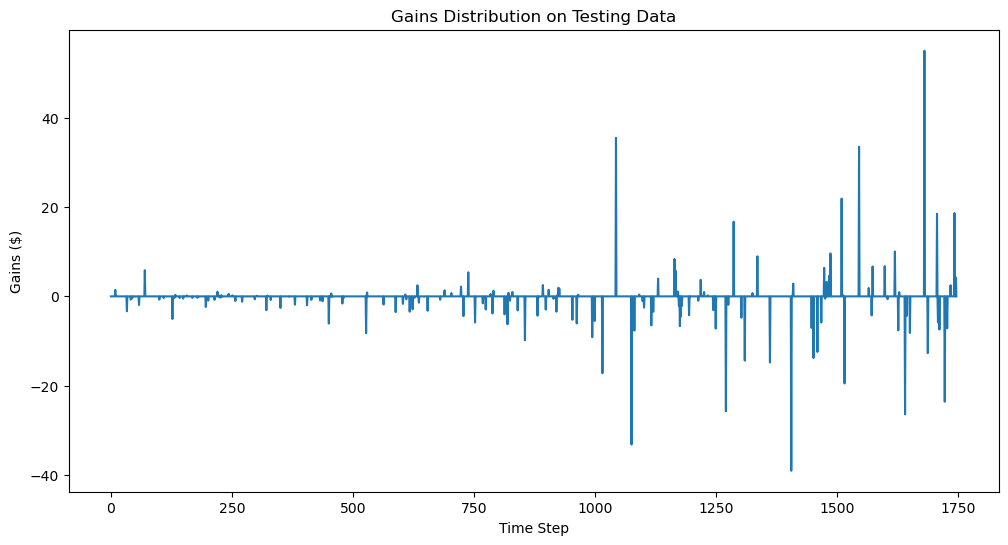

In [400]:
plt.figure(figsize=(12,6))
plt.plot(test_gains)
plt.title("Gains Distribution on Testing Data")
plt.xlabel("Time Step")
plt.ylabel("Gains ($)")
plt.show()

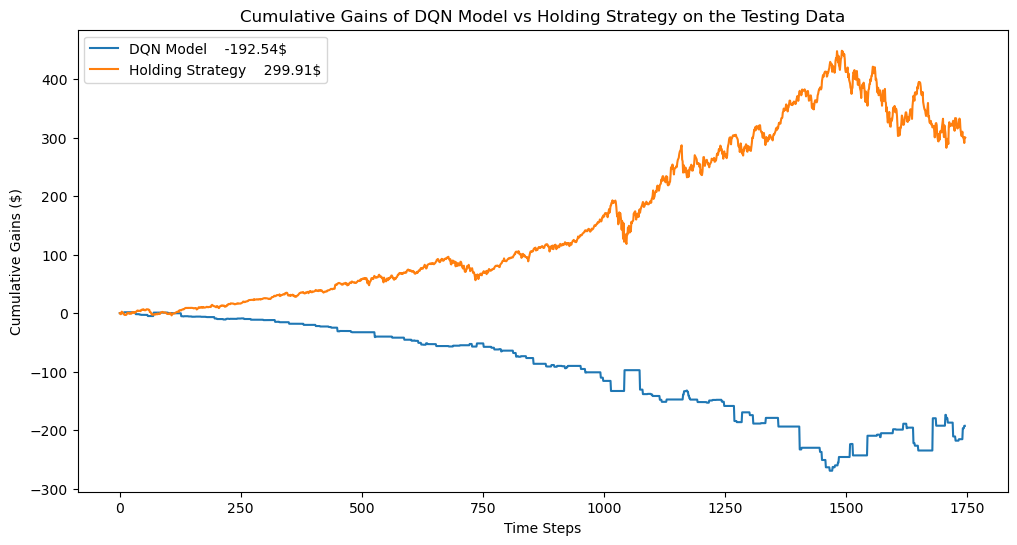

In [401]:
test_cumulative_gains = np.cumsum(test_gains)
plt.figure(figsize=(12,6))
plt.plot(test_cumulative_gains, label="DQN Model    {0:.2f}$".format(test_cumulative_gains[-1]))
test_holding_gains = np.sum(test_prices_unnorm-test_prices_unnorm[0], axis=1)
plt.plot(test_holding_gains, label="Holding Strategy    {0:.2f}$".format(test_holding_gains[-1]))
plt.title("Cumulative Gains of DQN Model vs Holding Strategy on the Testing Data")
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Gains ($)")
plt.legend()
plt.show()